In [1]:
## custom
import lovasz_losses as L

## third party
from PIL import Image
from natsort import natsorted

## sys
import random
import time
from glob import glob

## numeric
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
import umap.plot
from umap import UMAP

## vis
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits import mplot3d
from matplotlib import collections  as mc
from mpl_toolkits.mplot3d.art3d import Line3DCollection

## notebook
from IPython import display
from tqdm import tqdm_notebook as tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = 'cpu'
plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')

## Utils

In [2]:
def colorScale2cmap(domain, range1):
    domain = np.array(domain)
    domain = (domain-domain.min())/(domain.max()-domain.min())
    range1 = np.array(range1)/255.0
    red = [r[0] for r in range1]
    green = [r[1] for r in range1]
    blue = [r[2] for r in range1]
    red = tuple((d,r,r) for d,r in zip(domain, red))
    green = tuple((d,r,r) for d,r in zip(domain, green))
    blue = tuple((d,r,r) for d,r in zip(domain, blue))
    return LinearSegmentedColormap('asdasdas', {'red':red, 'green': green, 'blue':blue})
    

#https://discuss.pytorch.org/t/efficient-distance-matrix-computation/9065/3
def pairwise_distances(x, y=None, w=None):
    '''
    Input: x is a Nxd matrix
           y is an optional Mxd matirx
    Output: dist is a NxM matrix where dist[i,j] is the square norm between x[i,:] and y[j,:]
            if y is not given then use 'y=x'.
    i.e. dist[i,j] = ||x[i,:]-y[j,:]||^2
    '''
    x_norm = (x**2).sum(1).view(-1, 1)
    if y is None:
        y = x
        y_t = y.t()
        y_norm = x_norm
    else:
        y_t = y.t()
        y_norm = (y**2).sum(1).view(1, -1)
        
    if w is not None:
        x = x * w    
        y = y * w    
    dist = x_norm + y_norm - 2.0 * torch.mm(x, y_t)
    return torch.clamp(dist, 0.0, np.inf)

x = torch.ones([5,2])
y = torch.zeros([3,2])
pairwise_distances(x,y)

tensor([[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]])

In [3]:
def file2graph(fn='./facebook/0.edges'):
    with open(fn) as f:
        lines = [l.split()[:2] for l in f.readlines()]
        edges = [tuple(int(i) for i in l) for l in lines]
        nodes = set(sum(edges, ())) ## SLOW?
#         edges += [(-1, n) for n in nodes]
#         nodes.update({-1})
    G = nx.Graph()
    G.add_nodes_from(list(nodes))
    G.add_edges_from(edges)
    return G


def dict2tensor(d, fill=None):
    n = len(d.keys())
    k2i = {k:i for i,k in enumerate(sorted(d.keys()))}
    res = torch.zeros(len(d.keys()), len(d.keys()), device=device)
    for src_node, dst_nodes in d.items():
        for dst_node, distance in dst_nodes.items():
            if fill is not None:
                res[k2i[src_node],k2i[dst_node]] = fill
            else:
                res[k2i[src_node],k2i[dst_node]] = distance
    return res, k2i


def draw_graph_3d(ax, x, G, grad=None):
    ax.scatter(x[:,0], x[:,1], x[:,2])
    # ax.view_init(elev=20.0, azim=0)
    edgeLines = [(x[k2i[e0]][:3], x[k2i[e1]][:3]) for e0,e1 in G.edges]
    lc = Line3DCollection(edgeLines, linewidths=1, alpha=0.2)
    ax.add_collection(lc)
    if grad is not None:
        ax.quiver(x[:,0], x[:,1], x[:,2], 
                 -grad[:,0], -grad[:,1], -grad[:,2], length=4, colors='C1')
    return ax


def plot(X, pred, G, Adj, lossHistory, jaccardHistory, lrHistory, i, totalTime, show=True, save=True, grad=True):
    x = X.detach().cpu().numpy()
    
    if grad:
        grad = X.grad.data.cpu().numpy()
    else:
        grad = None
        
    fig = plt.figure(figsize=[12,10])
    if show:
        display.clear_output(wait=True)

    ## graph
    if x.shape[1] == 2:
        plt.subplot(221)
        nx.draw_networkx(G, 
                         pos={k: x[k2i[k],:2] for k in G.nodes}, 
                         node_size=30,
                         font_color='none')
        if grad is not None:
            plt.quiver(x[:,0], x[:,1], 
                       -grad[:,0], -grad[:,1], 
                       units='inches', label=f'neg grad (max={np.linalg.norm(grad, axis=1).max():.2e})')
            plt.legend()
        plt.axis('equal')
        
    else:
        ax = fig.add_subplot(1,3,1, projection='3d')
        ax = draw_graph_3d(ax, x, G, grad)
    plt.title(f'epoch: {i}, time: {int(totalTime)}s'.format(i))

    ## loss
    plt.subplot(222)
    plt.plot(lossHistory)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    ## Jaccard
    plt.subplot(223)
    plt.plot(jaccardHistory)
    plt.xlabel('Epoch')
    plt.ylabel('Jaccard')
    
    ## Lr
    plt.subplot(224)
    plt.plot(lrHistory)
    plt.xlabel('Epoch')
    plt.ylabel('LR')

    
#     ## pred vs truth
#     plt.subplot(234)
#     pdist = pairwise_distances(X)
#     pdist = pdist.detach().cpu()
#     plt.imshow(pdist)
#     plt.title('pairwise distance')
#     plt.colorbar()

#     plt.subplot(235)
#     pred = pred.detach().cpu()
#     vmax = min(pred.max(), -pred.min())
#     cmap = colorScale2cmap([-1, 0, 1], colors)
#     plt.imshow(pred, cmap=cmap, vmin=-0.1, vmax=0.1)
#     plt.title('Prediction')
#     plt.colorbar()

#     plt.subplot(236)
#     cmap = colorScale2cmap([0, 0.5, 1], colors)
#     plt.imshow(Adj.detach().cpu(), cmap=cmap)
#     plt.colorbar()
#     plt.title('Ground Truth')
    
    if save:
        plt.savefig(f'fig/epoch{i}.png')
    
    if show:
        plt.show()
    else:
        plt.close()



colors = [
    [44,52,179],
    [0,0,0],
    [174,33,57],
]

## Optimization Procedures

In [4]:
## model
def euclidean_neighbor(x, samples=None, subgraph=None):
    nodeCount = x.shape[0]
    
    if samples is not None:
        x,y = x[samples,:], x
    elif subgraph is not None:
        x,y = x[samples,:], x[samples,:]
    else:
        x,y = x, x
        
    pdist = pairwise_distances(x, y)
    res = torch.zeros([x.shape[0], y.shape[0]], device=device)
    
    for i, [distances, ns] in enumerate(zip(pdist, neighborSizes)):
        k = nodeCount-ns.item()
        topk = distances.topk(k)
        thresh = topk.values[-2:].mean()
        res[i,:] = -(pdist[i,:]-thresh)
#         res[i, truth[i].bool()] = res[i, truth[i].bool()]# + 1
#         res[i, ~truth[i].bool()] = -res[i, ~truth[i].bool()]# + 1
    return res


def jaccardIndex(pred, target):
    intersect = pred*target
    union = (pred+target).clamp(0,1)
    if intersect.sum() == 0:
        return torch.tensor(0.0)
    else:
#         print(intersect.sum().item(), union.sum().item())
        return intersect.sum() / union.sum()

## test:
logits = torch.tensor([1.0, 1.0, 1.0], requires_grad=True)
target = torch.tensor([1.0, 1.0, 1.0])
f = L.lovasz_hinge

print('jaccard index:', jaccardIndex(logits, target).item())
print(' jaccard loss:', 1-jaccardIndex(logits, target).item())
print('  lovasz loss:', f(logits, target).item())


## test
# ground_truth = torch.tensor([0.0, 0.0])
# steps = 19
# x,y = np.meshgrid(np.linspace(-2,2,steps).astype('float32'), np.linspace(-2,2,steps).astype('float32'))
# z = []
# for logits in np.c_[x.ravel(), y.ravel()]:
#     logits = torch.tensor(logits, requires_grad=True)
#     loss = f(logits, ground_truth).item()
#     z.append(loss)
# z = np.array(z)

# x = x.reshape([steps,steps])
# y = y.reshape([steps,steps])
# z = z.reshape([steps,steps])

# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.plot_surface(x,y,z, cmap='viridis')
# ax.view_init(elev=20.0, azim=210)
# plt.show()

jaccard index: 1.0
 jaccard loss: 0.0
  lovasz loss: 0.0


## generate a graph

In [5]:
## model
def euclidean_neighbor(x, margin=0, samples=None, subgraph=None):
    nodeCount = x.shape[0]
    
    if samples is not None:
        x,y = x[samples,:], x
    elif subgraph is not None:
        x,y = x[samples,:], x[samples,:]
    else:
        x,y = x, x
        
    pdist = pairwise_distances(x, y)
    res = torch.zeros([x.shape[0], y.shape[0]], device=device)
    
    for i, [distances, ns] in enumerate(zip(pdist, neighborSizes)):
        k = nodeCount-ns.item()
        topk = distances.topk(k)
        thresh = topk.values[-2:].mean()
        
        res[i,:] = pdist[i,:]-thresh
        res[i, res[i,:]>0] = res[i, res[i,:]>0]
        res[i, res[i,:]<0] = res[i, res[i,:]<0]
        res[i,:] = -res[i,:]
#         res[i, truth[i].bool()] = res[i, truth[i].bool()]# + 1
#         res[i, ~truth[i].bool()] = -res[i, ~truth[i].bool()]# + 1
    return res

In [508]:
%%time

print('generating graph...')
# G = nx.path_graph(10)
# G = nx.cycle_graph(10)
G = nx.balanced_tree(2,5)
# G = nx.connected_watts_strogatz_graph(10,5,0.5)
# G = file2graph('./facebook/0.edges')
# G = file2graph('./facebook/107.edges')
print(len(G.nodes), 'nodes')

print('calculating all pairs shortest path...')
D, k2i = dict2tensor(dict(nx.all_pairs_shortest_path_length(G)))
Adj,_ = dict2tensor(dict(G.adjacency()), fill=1)
print('\n\n')

neighborSizes = Adj.sum(dim=1).int()
nodeCount = Adj.shape[0]
eye = torch.eye(Adj.shape[0], device=device)
truth = Adj + eye


generating graph...
63 nodes
calculating all pairs shortest path...



CPU times: user 66.6 ms, sys: 145 µs, total: 66.8 ms
Wall time: 65.2 ms


## Optimize via Stochastic Gradient Descent (SGD)

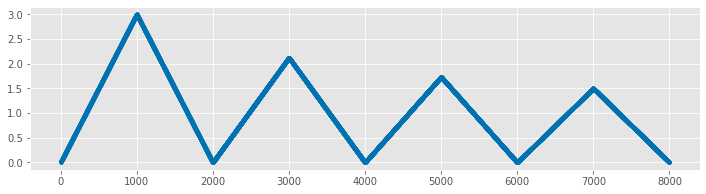

In [520]:
# mapper = UMAP(n_components=2, 
#             n_neighbors=50,
#             min_dist=0.99,
#             metric='precomputed')
# dist = D.detach().cpu()
# xy = mapper.fit_transform(dist)


# if xy.shape[1] == 2:
#     plt.figure(figsize=[4,4])
#     nx.draw_networkx(G, 
#                     pos={k: xy[k2i[k],:2] for k in G.nodes}, 
#                     node_size=30,
#                     font_color='none', 
#                     edge_color=[0.0, 0.0, 0.0, 0.1])
# else:
#     fig = plt.figure(figsize=[6,6])
#     ax = fig.add_subplot(1,1,1, projection='3d')
#     ax = draw_graph_3d(ax, xy, G, None)
# plt.show()

# delete old
!rm -r fig
!mkdir fig


X = torch.rand(len(G.nodes), 2, device=device)
# X = torch.from_numpy(xy).clone()
X.requires_grad_(True)

##functions
sigmoid = nn.Sigmoid()
jaccard_loss = L.lovasz_hinge

lossHistory = []
jaccardHistory = []
lrHistory = []
lr=3
step_size_up = 1000
step_size_down = 1000
niter = (step_size_up+step_size_down)*4
optimizer = optim.SGD([X], lr=lr)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, niter, eta_min=0.0, last_epoch=-1)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, 
                                        base_lr=0.0, 
                                        max_lr=lr, 
                                        step_size_up = step_size_up,
                                        step_size_down = step_size_down,
                                        scale_fn=lambda x:1/x**0.5
                                       )
lrs = []
for i in range(niter):
    scheduler.step()
    lrs.append(optimizer.param_groups[0]['lr'])
plt.figure(figsize=[12,3])
plt.plot(lrs, '.')
plt.show()

In [521]:
## eye = torch.eye(X.shape[0], device=device)

isStochastic = True
# isStochastic = False

iterBar = tqdm(range(niter))
totalTime = 0
for i in iterBar:
    
    t0 = time.time()
    if X.grad is not None:
        X.grad.data.fill_(0)
        
    if not isStochastic:
        pred = euclidean_neighbor(X)
        pred *= (1-eye)
        truth_i *= (1-eye)
        loss = jaccard_loss(pred.view(-1), truth_i.view(-1))
    else:
        sampleSize = 1
        indices = np.random.randint(0, X.shape[0], size=sampleSize)
        pred = euclidean_neighbor(X, samples=indices)
        truth_i = truth[indices, :]
        pred *= (1-eye[indices,:])
        truth_i *= (1-eye[indices,:])
        loss = jaccard_loss(pred.view(-1), truth_i.view(-1))
    loss.backward()
#     X.grad = X.grad.sign() ##fast grad sign
    optimizer.step()
    if scheduler is not None:
        scheduler.step()
    dt = time.time() - t0
    totalTime += dt
    
    ##debug info
    lossHistory.append(loss.item())
    lrHistory.append(optimizer.param_groups[0]['lr'])
    ##vis
    if i%100==0:
        pred = euclidean_neighbor(X, margin=1)
        pred *= (1-eye)
        jaccard = jaccardIndex((pred>0).float(), Adj).item()
        iterBar.set_postfix({'loss': loss.item(), 
                             'jaccard': jaccard, 
                             'lr': optimizer.param_groups[0]['lr']
                            })
        jaccardHistory.append(jaccard)
        plot(X, pred, G, Adj, lossHistory, jaccardHistory, lrHistory, i, totalTime, show=False, save=True, grad=False)
    

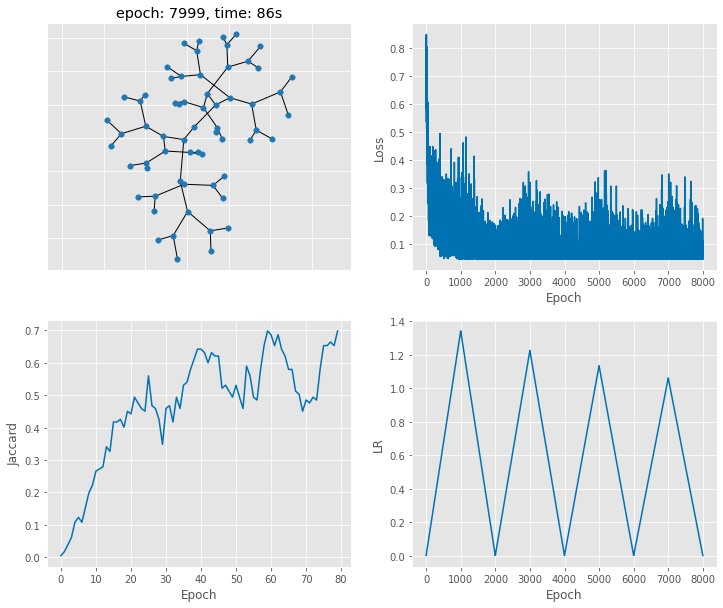

In [522]:
pred = euclidean_neighbor(X, margin=1)
plot(X, pred, G, Adj, lossHistory, jaccardHistory, lrHistory, i, totalTime, show=True, save=False, grad=False)

## animation

In [523]:
# Create a gif from images in fig/

frames = []
imgs = natsorted(glob('fig/*.png'))

for img in imgs:
    new_frame = Image.open(img)
    frames.append(new_frame)

# Save into a GIF file that loops forever
frames[0].save(f'anim-{int(time.time())}.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=60, loop=0)

# GD Via UMAP

In [ ]:
# %%time

# print('generating graph...')
# # G = nx.path_graph(10)
# # G = nx.cycle_graph(10)
# G = nx.balanced_tree(3,6)
# # G = nx.connected_watts_strogatz_graph(10,5,0.5)

# files = [1912, 107, 1684, 3437, 348, 0, 414, 686, 698, 3980,]
# # G = file2graph('./facebook/3980.edges')
# # G = file2graph('./facebook/698.edges')
# # G = file2graph('./facebook/414.edges')
# # G = file2graph('./facebook/0.edges')
# # G = file2graph('./facebook/686.edges')
# # G = file2graph(f'./facebook/{files[0]}.edges')
# print(len(G.nodes), 'nodes')

# print('calculating all pairs shortest path...')
# D, k2i = dict2tensor(dict(nx.all_pairs_shortest_path_length(G)))
# Adj,_ = dict2tensor(dict(G.adjacency()), fill=1)
# print('\n\n')

# neighborSizes = Adj.sum(dim=1).int()
# nodeCount = Adj.shape[0]
# eye = torch.eye(Adj.shape[0], device=device)
# truth = Adj + eye


In [ ]:
# plt.figure(figsize=[12,4])

# dist0 = 1-Adj.detach().cpu()
# dist0 += 1
# dist0 *= 1-torch.eye(Adj.shape[0])
# plt.subplot(121)
# plt.imshow(dist0)
# plt.colorbar()

# dist1 = D.detach().cpu()
# plt.subplot(122)
# plt.imshow(dist1)
# plt.colorbar()
# plt.show()


In [ ]:
# %%time

# mapper = UMAP(n_components=2, 
#             n_neighbors=15,
#             min_dist=0.6,
#             metric='precomputed')
# dist = dist1
# xy = mapper.fit_transform(dist)

# plt.figure(figsize=[12,12])
# nx.draw_networkx(G, pos={k: xy[k2i[k],:2] for k in G.nodes}, 
#                  font_color='white', 
#                  edge_color=[0.0, 0.0, 0.0, 0.1])


In [ ]:
# umap.plot.connectivity(mapper, edge_bundling='hammer')
# umap.plot.connectivity(mapper, show_points=True)

In [ ]:
# mapper = UMAP(n_components=3, 
#             n_neighbors=15, 
#             local_connectivity=2.0,
#             min_dist=0.01,
#             metric='precomputed')
# dist = dist1
# xyz = mapper.fit_transform(dist)

# fig = plt.figure(figsize=[12,12])
# ax = fig.add_subplot(1,1,1, projection='3d')
# ax = draw_graph_3d(ax, xyz, G, None)

In [ ]:
## notebook animation

# import imageio
# from natsort import natsorted
# from glob import glob

# fig = plt.figure(figsize=[14,10])

# ims = []
# for fn in natsorted(glob('fig/epoch*.png')):
#     im = imageio.imread(fn)
#     im = plt.imshow(im, animated=True)
#     ims.append([im])

# ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
#                                 repeat_delay=1000)

# # ani.save('dynamic_images.mp4')

# display.HTML(ani.to_jshtml())
# # plt.show()